In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
SEED = 60
EPOCHS = 120
LR = 0.001
DROPOUT = 0.2
VAL_SPLIT = 0.2
BATCH_SIZE = 14
WEIGHT_DECAY = 1e-4

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(torch.cuda.get_arch_list())
print(torch.cuda.is_available())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


['sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90']
True
Using device: cuda


In [1]:
# Load dataset (expects a single .pt file saved as a list of PyG Data objects)
from pathlib import Path
from torch_geometric.loader import DataLoader

BASE_DIR = Path.cwd().parent
DATASET_FILE = BASE_DIR / "GCN" / "training_ready_dataset15.pt"

if DATASET_FILE.exists():
    dataset = torch.load(DATASET_FILE, weights_only=False)
    print(f"Loaded dataset with {len(dataset)} graphs from {DATASET_FILE}")
else:
    dataset = []
    print(f"Dataset file not found at {DATASET_FILE}. Add data or build dataset first.")

# Basic sanity check
if len(dataset) > 0:
    assert hasattr(dataset[0], 'x') and hasattr(dataset[0], 'edge_index') and hasattr(dataset[0], 'y'), \
        "Each Data must have x, edge_index, and y"
    print(f"First object: {dataset[0]}")
    print(f"Number of classes: {dataset[0].y.max().item() + 1}")
    print(f"Number of attributes: {dataset[0].x.size(-1)}")




labels = [int(d.y.item()) for d in dataset]
train_data, val_data = train_test_split(dataset, test_size=VAL_SPLIT, stratify=labels, random_state=SEED)

graph_train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
graph_val_loader   = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

print("train graphs:", len(train_data))
print("val graphs:", len(val_data))



NameError: name 'torch' is not defined

In [4]:
from GCN import GCN3
from sklearn.utils.class_weight import compute_class_weight

in_channels = dataset[0].x.size(-1)
train_labels = [int(d.y.item()) for d in dataset]

model = GCN3(feature_dim_size=in_channels, dropout=DROPOUT).to(DEVICE)
weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=train_labels)
weights = torch.tensor(weights, dtype=torch.float).to(DEVICE)
#criterion = nn.CrossEntropyLoss(label_smoothing=0.05, weight=weights)
criterion = nn.CrossEntropyLoss(weight=weights)
#criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=10)

print(model)

# Batch training helpers
def train_one_epoch_batch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        
        # Forward pass with batch
        out = model(features=batch.x, adj=batch.edge_index, batch=batch.batch)
        loss = criterion(out, batch.y)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch.num_graphs
        preds = out.argmax(dim=1)
        correct += int((preds == batch.y).sum().item())
        total += batch.num_graphs

    avg_loss = total_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc


def evaluate_batch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(DEVICE)
            out = model(features=batch.x, adj=batch.edge_index, batch=batch.batch)
            loss = criterion(out, batch.y)
            
            total_loss += loss.item() * batch.num_graphs
            preds = out.argmax(dim=1)
            correct += int((preds == batch.y).sum().item())
            total += batch.num_graphs
    
    avg_loss = total_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc

GCN3(
  (conv1): GCNConv(14, 48)
  (conv2): GCNConv(48, 48)
  (conv3): GCNConv(48, 48)
  (fc1): Linear(in_features=96, out_features=48, bias=True)
  (out): Linear(in_features=48, out_features=2, bias=True)
)


In [5]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch_batch(model, graph_train_loader, optimizer, criterion)
    
    if len(graph_val_loader) > 0:
        vl_loss, vl_acc = evaluate_batch(model, graph_val_loader, criterion)
    else:
        vl_loss, vl_acc = 0.0, 0.0

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(vl_loss)
    history["val_acc"].append(vl_acc)

    scheduler.step(vl_loss)
    curr_lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch:03d} | Train Loss: {tr_loss:.4f} Acc: {tr_acc:.3f} | Val Loss: {vl_loss:.4f} Acc: {vl_acc:.3f}")

/home/mrestebato/.conda/envs/heatstakes/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch 001 | Train Loss: 24.8815 Acc: 0.456 | Val Loss: 4.3220 Acc: 0.508
Epoch 002 | Train Loss: 8.8183 Acc: 0.515 | Val Loss: 2.1938 Acc: 0.557
Epoch 003 | Train Loss: 4.4272 Acc: 0.523 | Val Loss: 2.0424 Acc: 0.541
Epoch 004 | Train Loss: 2.7087 Acc: 0.544 | Val Loss: 1.0964 Acc: 0.557
Epoch 005 | Train Loss: 1.4661 Acc: 0.477 | Val Loss: 1.1341 Acc: 0.607
Epoch 006 | Train Loss: 0.8366 Acc: 0.589 | Val Loss: 1.3947 Acc: 0.557
Epoch 007 | Train Loss: 0.8198 Acc: 0.548 | Val Loss: 0.8698 Acc: 0.607
Epoch 008 | Train Loss: 0.7413 Acc: 0.515 | Val Loss: 0.8627 Acc: 0.557
Epoch 009 | Train Loss: 0.7161 Acc: 0.510 | Val Loss: 0.8081 Acc: 0.541
Epoch 010 | Train Loss: 0.6939 Acc: 0.502 | Val Loss: 0.7510 Acc: 0.557
Epoch 011 | Train Loss: 0.7016 Acc: 0.485 | Val Loss: 0.7549 Acc: 0.557
Epoch 012 | Train Loss: 0.7083 Acc: 0.519 | Val Loss: 0.9395 Acc: 0.607
Epoch 013 | Train Loss: 0.6950 Acc: 0.519 | Val Loss: 1.3260 Acc: 0.623
Epoch 014 | Train Loss: 0.7185 Acc: 0.519 | Val Loss: 0.8246 Ac

In [7]:
# Overfit a batch of 10 graphs for debugging purposes

from torch_geometric.loader import DataLoader

subset_size = min(32, len(train_data))
if subset_size < 10:
    print(f"Only {subset_size} training graphs available; using all.")

small_subset = train_data[:subset_size]  # deterministic subset
small_loader = DataLoader(small_subset, batch_size=subset_size, shuffle=False)

# Optional: make overfitting easier
model.dropout = 0.0  # if your model uses self.dropout

for i in range(300):
    tr_loss, tr_acc = train_one_epoch_batch(model, small_loader, optimizer, criterion)
    if (i + 1) % 20 == 0:
        print(f"Iter {i+1:03d} | loss: {tr_loss:.4f} | acc: {tr_acc:.3f}")

print("Small-batch eval (should approach 1.0 acc):", evaluate_batch(model, small_loader, criterion))

/home/mrestebato/.conda/envs/heatstakes/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Iter 020 | loss: 0.7413 | acc: 0.344
Iter 040 | loss: 0.5795 | acc: 0.781
Iter 060 | loss: 0.5568 | acc: 0.844
Iter 080 | loss: 0.5477 | acc: 0.844
Iter 100 | loss: 0.5436 | acc: 0.844
Iter 120 | loss: 0.5400 | acc: 0.844
Iter 140 | loss: 0.5357 | acc: 0.844
Iter 160 | loss: 0.5303 | acc: 0.844
Iter 180 | loss: 0.5267 | acc: 0.812
Iter 200 | loss: 0.5243 | acc: 0.812
Iter 220 | loss: 0.5222 | acc: 0.812
Iter 240 | loss: 0.5201 | acc: 0.812
Iter 260 | loss: 0.5183 | acc: 0.812
Iter 280 | loss: 0.5161 | acc: 0.812
Iter 300 | loss: 0.5140 | acc: 0.812
Small-batch eval (should approach 1.0 acc): (0.5138684511184692, 0.8125)


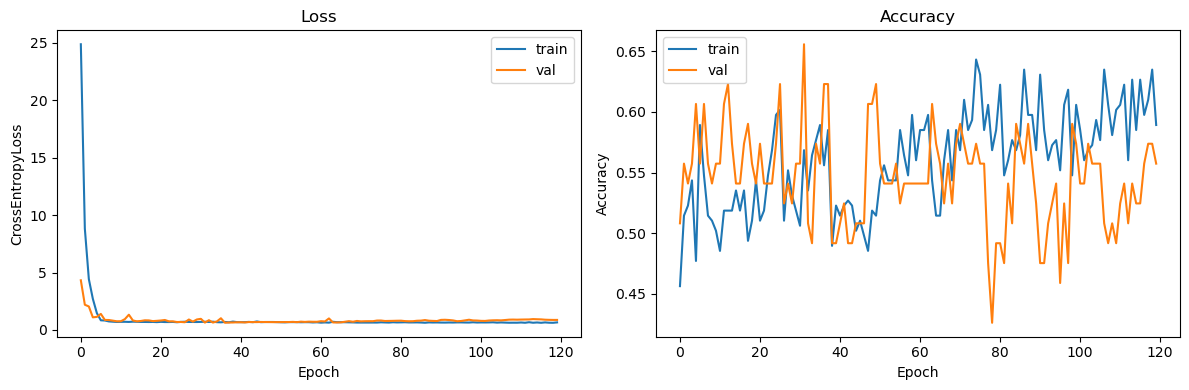

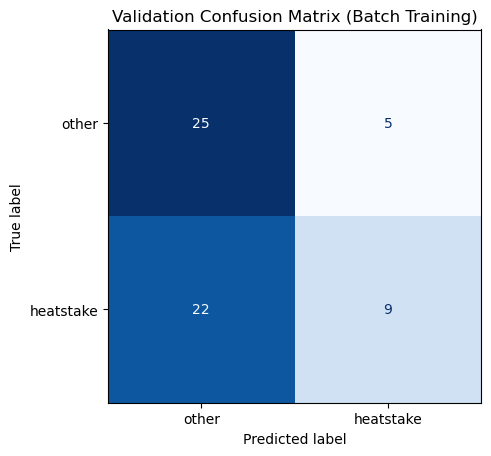


Validation Classification Report:
              precision    recall  f1-score   support

       other       0.53      0.83      0.65        30
   heatstake       0.64      0.29      0.40        31

    accuracy                           0.56        61
   macro avg       0.59      0.56      0.52        61
weighted avg       0.59      0.56      0.52        61



In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(history["train_loss"], label="train")
axs[0].plot(history["val_loss"], label="val")
axs[0].set_title("Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("CrossEntropyLoss")
axs[0].legend()

axs[1].plot(history["train_acc"], label="train")
axs[1].plot(history["val_acc"], label="val")
axs[1].set_title("Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

# Confusion Matrix for batch validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in graph_val_loader:
        batch = batch.to(DEVICE)
        logits = model(features=batch.x, adj=batch.edge_index, batch=batch.batch)  # [G, 2]
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(batch.y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_targets)

labels = [0, 1]
cm = confusion_matrix(y_true, y_pred, labels=labels)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["other", "heatstake"])
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Validation Confusion Matrix (Batch Training)")
plt.tight_layout()
plt.show()

print("\nValidation Classification Report:")
print(classification_report(y_true, y_pred, target_names=["other", "heatstake"]))